<a href="https://colab.research.google.com/github/NagaoTadashi/image_practice/blob/master/pytorch_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch 
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import vision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimizer

transformを定義(データを0～１に正規化した後－1～1に正規化している)

In [ ]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

学習データと検証データの用意

In [ ]:
train_data_with_teacher_labels=torchvision.datasets.CIFAR10(root="./data",train=True,download=True,transform=transform)
train_data_loader=torch.utils.data.DataLoader(train_data_with_teacher_labels,batch_size=4,shuffle=True,num_workers=2)

test_data_with_teacher_labels=torchvision.datasets.CIFAR10(root="./data",train=False,download=True,transform=transform)
test_data_loader=torch.utils.data.DataLoader(test_data_with_teacher_labels,batch_size=4,shuffle=True,num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
print(len(train_data_with_teacher_labels))
print(len(train_data_loader))
print(len(test_data_with_teacher_labels))
print(len(test_data_loader))

50000
12500
10000
2500


クラスの中身を設定

In [ ]:
class_names=("plane","car","bird","cat","deer","dog","frog","horse","ship","truck")

画像を表示する関数

In [ ]:
def show_image(img):
  img=img/2+0.5
  npimg=img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

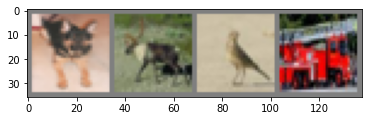

In [ ]:
data_iterator=iter(train_data_loader)
images,labels=data_iterator.next()
show_image(torchvision.utils.make_grid(images))

ニューラルネットワークの定義

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.conv1=nn.Conv2d(3,6,5) #(入力ch数、フィルタ数(出力ch数)、フィルタサイズ)
    self.pool=nn.MaxPool2d(2,2) #2×2のMaxプーリング
    self.conv2=nn.Conv2d(6,16,5)
    self.layer1=nn.Linear(16*5*5,120)
    self.layer2=nn.Linear(120,84)
    self.layer3=nn.Linear(84,10)

  def forward(self,input_data):
    input_data=self.conv1(input_data)
    input_data=F.relu(input_data)
    input_data=self.pool(input_data)
    #input_data=self.pool(F.relu(self.conv1(input_data)))
    input_data=self.conv2(input_data)
    input_data=F.relu(input_data)
    input_data=self.pool(input_data)
    #input_data=self.pool(F.relu(self.conv2(input_data)))
    input_data=input_data.view(-1,16*5*5)
    input_data=self.layer1(input_data)
    input_data=F.relu(input_data)
    #input_data=F.relu(self.layer1(input_data))
    input_data=self.layer2(input_data)
    input_data=F.relu(input_data)
    #input_data=F.relu(self.layer2(input_data))
    input_data=self.layer3(input_data)
    input_data=F.relu(input_data)
    #input_data=F.relu(self.layer3(input_data))
    return input_data
  
model=CNN()

optimizerの設定

In [ ]:
logloss=nn.CrossEntropyLoss()
optimizer=optimizer.SGD(model.parameters(),lr=0.01)

学習

In [ ]:
max_epoch=3
for epoch in range(max_epoch):
  for i ,data in enumerate(train_data_loader):
    train_data,teacher_labels=data
    optimizer.zero_grad()
    #順伝搬
    outputs=model(train_data)
    #誤差を算出
    loss=logloss(outputs,teacher_labels)
    #誤差逆伝搬
    loss.backward()
    #重み更新
    optimizer.step()

個別データで検証

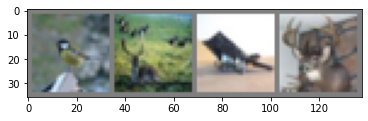

bird
deer
plane
deer
bird
frog
plane
dog


In [ ]:
data_iterator=iter(test_data_loader)
images,labels=data_iterator.next()
show_image(torchvision.utils.make_grid(images))
for i in labels:
  print(class_names[i])
outputs=model(images)
_,predicted=torch.max(outputs,1)
for i in predicted:
  print(class_names[i])

検証

In [ ]:
total=0
count_when_correct=0
for data in test_data_loader:
  test_data,teacher_labels=data
  results=model(test_data)
  _,predicted=torch.max(results,1)
  total+=teacher_labels.size(0)
  count_when_correct+=(predicted==teacher_labels).sum().item()
print(count_when_correct)

5749
